In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("chicago_crime_final.csv", encoding='utf-8', low_memory=False)

건수: 0건


In [5]:
arrest_rate_by_beat = df.groupby("Beat")["Arrest"].mean()

In [32]:
from scipy.stats import shapiro

# 사건 수가 충분한 Beat만 선택 (예: 100건 이상)
beat_counts = df['Beat'].value_counts()
valid_beats = beat_counts[beat_counts >= 100].index.tolist()
df_valid = df[df['Beat'].isin(valid_beats)].copy()

# Arrest를 수치형으로 변환
df_valid['Arrest_numeric'] = df_valid['Arrest'].astype(int)

# Beat별로 나눈 후 정규성 검정
shapiro_results = {}
for beat, group in df_valid.groupby('Beat'):
    sample = group['Arrest_numeric'].values
    if len(sample) >= 3:  # 샤피로 검정 최소 샘플 3개 필요
        stat, p = shapiro(sample[:500])  # 너무 많으면 오류 → 상위 500개만 사용
        shapiro_results[beat] = p

# 예: 평균 p-value 구하기
mean_shapiro_p = sum(shapiro_results.values()) / len(shapiro_results)
print("평균 Shapiro-Wilk p-value:", mean_shapiro_p)

# 예: 정규성 만족하는 Beat 개수 확인
print(" 정규성 만족 (p > 0.05):", sum(p > 0.05 for p in shapiro_results.values()))


평균 Shapiro-Wilk p-value: 7.38960811189982e-28
 정규성 만족 (p > 0.05): 0


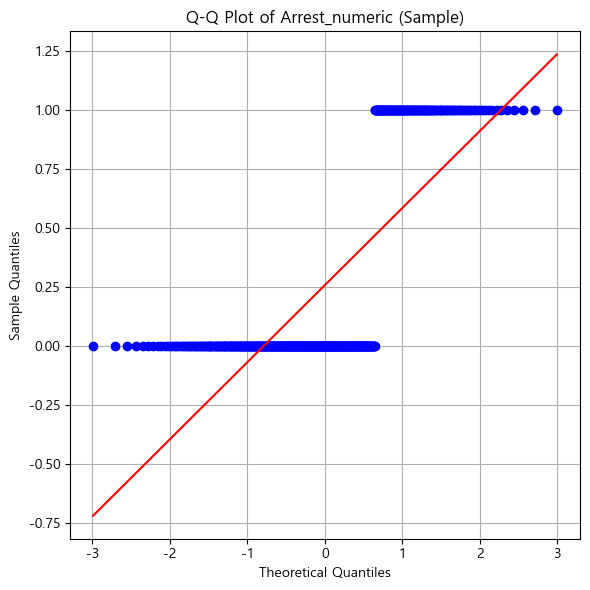

In [54]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# 예: 특정 Community Area 또는 전체 Arrest_numeric 중 일부 추출
sample = df_valid['Arrest_numeric'].sample(500)  # 너무 크면 왜곡 → 일부 샘플

# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(sample, dist="norm", plot=plt)
plt.title("Q-Q Plot of Arrest_numeric (Sample)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from scipy.stats import levene

# Beat별 체포율 리스트 (100건 이상만 포함)
grouped_arrests = [
    group['Arrest_numeric'].values
    for _, group in df_valid.groupby('Beat')
]

# Levene's test (등분산성 검정)
levene_stat, levene_p = levene(*grouped_arrests)

print("Levene’s test p-value:", levene_p)
if levene_p < 0.05:
    print(" 등분산성 없음 (귀무가설 기각)")
else:
    print(" 등분산성 있음 (귀무가설 채택)")

Levene’s test p-value: 0.0
 등분산성 없음 (귀무가설 기각)


In [33]:
from scipy.stats import kruskal
import pandas as pd

# 1. Beat별 사건 수 계산 후, 최소 100건 이상인 Beat만 선택
beat_counts = df['Beat'].value_counts()
valid_beats = beat_counts[beat_counts >= 100].index.tolist()
df_valid = df[df['Beat'].isin(valid_beats)].copy()

# 2. 체포 여부를 숫자로 변환 (True → 1, False → 0)
df_valid['Arrest_numeric'] = df_valid['Arrest'].astype(int)

# 3. Beat별로 체포율 데이터 그룹화
grouped_arrests = [
    group['Arrest_numeric'].values
    for _, group in df_valid.groupby('Beat')
]

# 4. Kruskal-Wallis H-test 실행
stat, p = kruskal(*grouped_arrests)

# 5. 결과 출력
print("Kruskal-Wallis H-statistic:", stat)
print("p-value:", p)

# 6. 해석 출력
if p < 0.05:
    print("순찰 구역(Beat)에 따라 체포율에 유의미한 차이가 있습니다. (귀무가설 기각)")
else:
    print("순찰 구역(Beat)에 따라 체포율 차이는 통계적으로 유의하지 않습니다. (귀무가설 채택)")


Kruskal-Wallis H-statistic: 301816.1110578245
p-value: 0.0
순찰 구역(Beat)에 따라 체포율에 유의미한 차이가 있습니다. (귀무가설 기각)


In [37]:
df['Beat'].value_counts().head(10)

Beat
421     64321
423     63241
1834    61506
624     58136
511     56638
1533    55309
1112    55132
823     54842
414     51814
1522    50867
Name: count, dtype: int64

In [9]:
pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


In [15]:
import scikit_posthocs as sp
import pandas as pd

# Beat별 사건 수 확인해서 100건 이상만 필터링 (이미 진행한 기준)
beat_counts = df['Beat'].value_counts()
valid_beats = beat_counts[beat_counts >= 100].index.tolist()
df_valid = df[df['Beat'].isin(valid_beats)].copy()

# Arrest를 숫자형으로 변환
df_valid['Arrest_numeric'] = df_valid['Arrest'].astype(int)

# Dunn's test 실행 (전체 Beat 대상, Bonferroni 보정 포함)
dunn_result = sp.posthoc_dunn(
    df_valid,
    val_col='Arrest_numeric',
    group_col='Beat',
    p_adjust='bonferroni'
)

# 결과를 보기 좋게 소수점 4자리로 반올림
dunn_result_rounded = dunn_result.round(4)

# 결과 저장 또는 출력
dunn_result_rounded


,111,112,113,114,121,122,123,124,131,132,...,2521,2522,2523,2524,2525,2531,2532,2533,2534,2535
111,1.0,0.0000,0.0,0.0,0.0000,0.0,1.0000,1.0,1.0000,0.0863,...,1.0,1.0000,0.0000,0.0149,1.0000,0.0000,0.0000,0.0000,0.0,0.0000
112,0.0,1.0000,0.0,0.0,0.0048,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
113,0.0,0.0000,1.0,0.0,0.0000,0.0,0.0000,1.0,0.0000,0.0000,...,1.0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
114,0.0,0.0000,0.0,1.0,1.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
121,0.0,0.0048,0.0,1.0,1.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0081,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2531,0.0,0.0000,0.0,0.0,0.0000,1.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,0.0013,0.0000,1.0,0.0000
2532,0.0,0.0000,0.0,0.0,0.0000,1.0,0.0125,0.0,1.0000,1.0000,...,0.0,0.0001,0.0000,0.0000,0.0473,0.0013,1.0000,0.0000,1.0,0.0000
2533,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0,0.0238
2534,0.0,0.0000,0.0,0.0,0.0000,1.0,0.0000,0.0,0.0001,0.0004,...,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0,0.0000


In [24]:
top_beats = df['Beat'].value_counts().head(20).index.tolist()
df_top = df_valid[df_valid['Beat'].isin(top_beats)]

# Dunn's test 
import scikit_posthocs as sp
dunn_top = sp.posthoc_dunn(df_top, val_col='Arrest_numeric', group_col='Beat', p_adjust='bonferroni')
dunn_top.round(4)


,321,414,421,423,511,512,522,612,621,624,631,823,825,1011,1112,1522,1533,1831,1834,2533
321,1.0,0.0000,0.0000,0.000,0.0000,1.0,0.0,0.0000,0.0,1.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
414,0.0,1.0000,0.0000,0.000,0.0678,0.0,0.0,0.0000,0.0,0.0,1.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
421,0.0,0.0000,1.0000,1.000,0.0000,0.0,0.0,0.0423,0.0,0.0,0.0000,1.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
423,0.0,0.0000,1.0000,1.000,0.0000,0.0,0.0,0.1770,0.0,0.0,0.0000,1.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
511,0.0,0.0678,0.0000,0.000,1.0000,0.0,0.0,0.0000,0.0,0.0,0.0014,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
512,1.0,0.0000,0.0000,0.000,0.0000,1.0,0.0,0.0000,0.0,1.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
522,0.0,0.0000,0.0000,0.000,0.0000,0.0,1.0,0.0000,1.0,0.0,0.0000,0.0,1.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
612,0.0,0.0000,0.0423,0.177,0.0000,0.0,0.0,1.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
621,0.0,0.0000,0.0000,0.000,0.0000,0.0,1.0,0.0000,1.0,0.0,0.0000,0.0,1.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000
624,1.0,0.0000,0.0000,0.000,0.0000,1.0,0.0,0.0000,0.0,1.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000


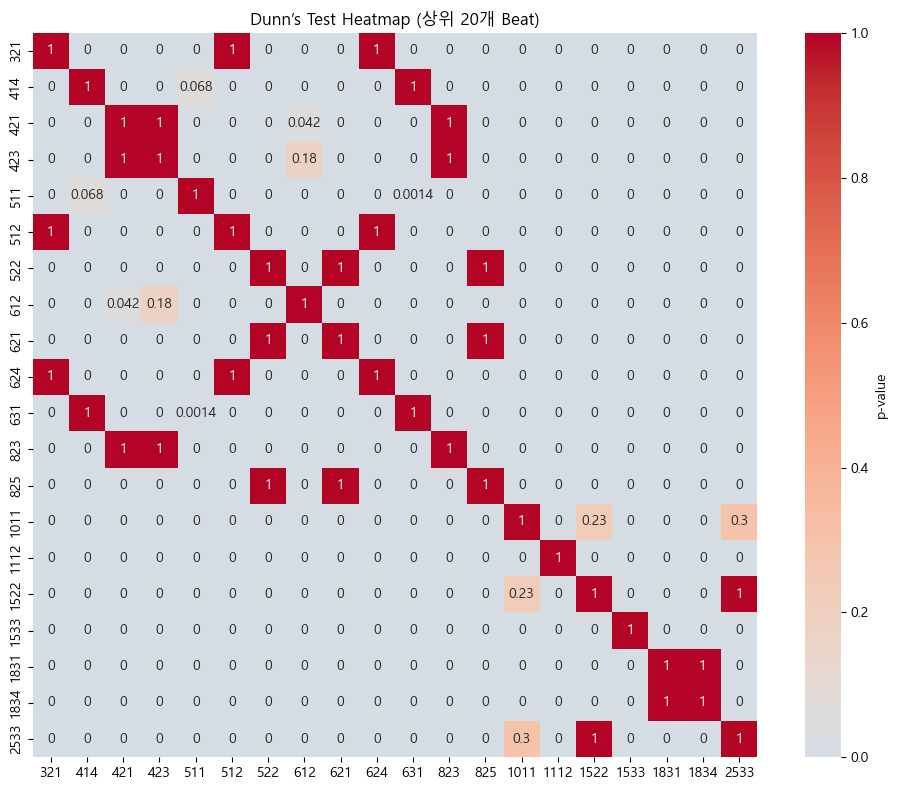

In [29]:
# 사건 수 많은 Beat 상위 20개만 선택
top_beats = df['Beat'].value_counts().head(20).index.tolist()
df_top = df_valid[df_valid['Beat'].isin(top_beats)]

# Dunn’s test 
dunn_top = sp.posthoc_dunn(df_top, val_col='Arrest_numeric', group_col='Beat', p_adjust='bonferroni')
dunn_top_rounded = dunn_top.round(4)

# 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(dunn_top_rounded, annot=True, cmap="coolwarm", center=0.05,
            square=True, cbar_kws={'label': 'p-value'})
plt.title("Dunn’s Test Heatmap (상위 20개 Beat)")
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd

# 1. 사건 수 100건 이상인 Beat만 필터링
beat_counts = df['Beat'].value_counts()
valid_beats = beat_counts[beat_counts >= 100].index.tolist()
df_valid = df[df['Beat'].isin(valid_beats)].copy()

# 2. 체포 여부 숫자형으로 변환
df_valid['Arrest_numeric'] = df_valid['Arrest'].astype(int)

# 3. Beat별 평균 체포율 계산
mean_arrest_by_beat = df_valid.groupby("Beat")["Arrest_numeric"].mean()

# 상위 10개 체포율 높은 Beat
top10 = mean_arrest_by_beat.sort_values(ascending=False).head(10)
print("평균 체포율 상위 10개 Beat:")
print(top10)

# 하위 10개 체포율 낮은 Beat
bottom10 = mean_arrest_by_beat.sort_values().head(10)
print("\n평균 체포율 하위 10개 Beat:")
print(bottom10)


평균 체포율 상위 10개 Beat:
Beat
134     0.517292
2113    0.515802
1112    0.480973
1131    0.480143
1531    0.463072
1114    0.458230
1113    0.447765
1115    0.445855
2311    0.444186
1134    0.442552
Name: Arrest_numeric, dtype: float64

평균 체포율 하위 10개 Beat:
Beat
1650    0.007519
1214    0.061116
235     0.066978
1935    0.071388
1215    0.082931
1934    0.099911
1814    0.102034
1621    0.109000
1813    0.115481
1614    0.115783
Name: Arrest_numeric, dtype: float64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '134'),
  Text(1, 0, '2113'),
  Text(2, 0, '1112'),
  Text(3, 0, '1131'),
  Text(4, 0, '1531'),
  Text(5, 0, '1114'),
  Text(6, 0, '1113'),
  Text(7, 0, '1115'),
  Text(8, 0, '2311'),
  Text(9, 0, '1134'),
  Text(10, 0, '1650'),
  Text(11, 0, '1214'),
  Text(12, 0, '235'),
  Text(13, 0, '1935'),
  Text(14, 0, '1215'),
  Text(15, 0, '1934'),
  Text(16, 0, '1814'),
  Text(17, 0, '1621'),
  Text(18, 0, '1813'),
  Text(19, 0, '1614')])

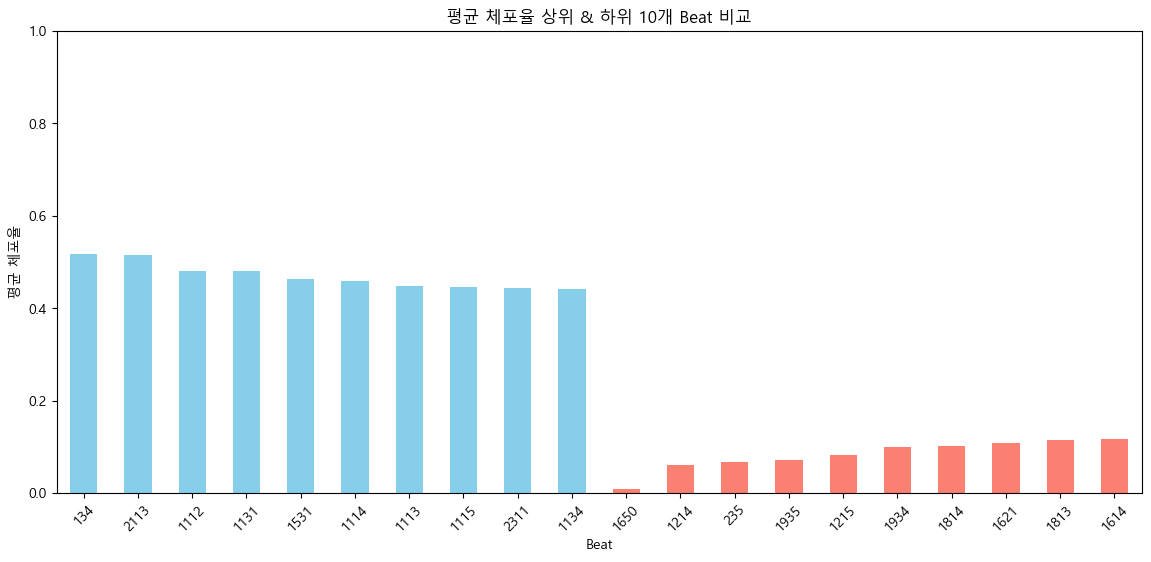

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# 체포 여부를 숫자로 변환
df['Arrest_numeric'] = df['Arrest'].astype(int)

# 사건 수 100건 이상인 Beat만 필터링
beat_counts = df['Beat'].value_counts()
valid_beats = beat_counts[beat_counts >= 100].index.tolist()
df_valid = df[df['Beat'].isin(valid_beats)].copy()

# 평균 체포율 계산
mean_arrest_by_beat = df_valid.groupby("Beat")["Arrest_numeric"].mean()

# 상위 10개 & 하위 10개 추출
top10 = mean_arrest_by_beat.sort_values(ascending=False).head(10)
bottom10 = mean_arrest_by_beat.sort_values().head(10)

# 상하위 10개 합치기
combined = pd.concat([top10, bottom10])
colors = ['skyblue'] * 10 + ['salmon'] * 10  # 상위=파랑, 하위=빨강

# Barplot 시각화
plt.figure(figsize=(14, 6))
combined.plot(kind='bar', color=colors)
plt.title("평균 체포율 상위 & 하위 10개 Beat 비교")
plt.ylabel("평균 체포율")
plt.ylim(0, 1)
plt.xticks(rotation=45)



In [34]:
#가설 : "경찰 순찰 구역(Beat)에 따라 체포율(Arrest)이 다를 것이다."

#귀무가설 (H₀): 모든 Beat 간 체포율의 분포는 같다.
#대립가설 (H₁): 적어도 하나 이상의 Beat에서 체포율이 다르다.

# - 데이터 정제 - 
#샘플 수가 너무 적은 Beat는 통계적으로 불안정하고 분석 왜곡 우려
#100건 이상 사건이 발생한 Beat만 필터링 → 분석의 신뢰도 확보

#정규성 & 등분산성 전제 검정
#WHY? ANOVA를 쓸 수 있는지 확인하기 위해 

# 결과: 정규성 없음 (Shapiro-Wilk 평균 p ≈ 0) ,등분산성 없음 (Levene’s p ≈ 0) , 전제 조건을 충족하지 않으므로, ANOVA 대신 비모수 검정(Kruskal-Wallis) 사용
# Kruskal-Wallis 검정 (비모수) : 여러 그룹의 중앙값 차이를 비교 , 정규성·등분산성 전제가 깨진 경우에도 안전하게 쓸 수 있는 방법
# 결과: H-statistic = 3761.31, p < 0.001 → 귀무가설 기각 , Beat에 따라 체포율 차이가 있음을 통계적으로 확인

#사후 분석 (Dunn’s test) : Kruskal-Wallis는 "차이가있다는것만 " 알려주는 과정 따라서, 어느 Beat와 어느 Beat 사이에 차이가 있나?를 알려주는 사후 검정 필요
# 분석 결과 : Dunn’s 사후검정 결과, Beat 321과 414, Beat 511과 631 등 다수의 구역 쌍에서 체포율에 통계적으로 유의미한 차이(p < 0.05)가 나타났다.
#반면, Beat 421과 423, Beat 1831과 1834는 차이가 없었다(p ≥ 0.05).
#이는 지역 간 경찰 대응력, 범죄 유형, 사건 특성 등 외적 요인에 따라 체포율이 달라질 수 있음을 시사한다.

#유의미한 차이가 있는 Beat 쌍 (p < 0.05)
#321 vs 414, 421, 423, 511, 631, 823, 825 등 → 차이 있음
#511 vs 631 → p = 0.0014 → 체포율 분포가 확연히 다름
#421 vs 612 → p = 0.0423 → 유의미한 차이 경계선
#이러한 결과는 Beat별 경찰 대응, 체포 정책, 범죄 유형 등의 차이를 반영할 가능성이 있음

#유의미한 차이가 없는 쌍 (p ≥ 0.05, 예: p=1.0)
#1831 vs 1834 → p = 1.0
#421 vs 423 → p = 1.0
#1112 vs 1522 → p = 0.23
#1011 vs 2533 → p = 0.30
#이 구역들은 체포율이 통계적으로 동일한 수준이며, 유사한 대응 방식이 적용됐을 가능성 또는 비슷한 범죄 환경을 공유할 수 있음

#           상위 Beat	             하위 Beat
#체포율 수준	 44~52%	                 0.7~11%
#지역군	1100, 1300, 1500번대 중심	 1200, 1600, 1800, 1900번대 중심
#시사점	경찰 대응력 우수	            구조적 문제 가능성 존재
#정책적 의미	모범사례 확산 필요     	집중 개선/지원 대상 지역




In [52]:
import pandas as pd
from scipy.stats import shapiro, levene, kruskal

# Arrest를 숫자로 변환
df['Arrest_numeric'] = df['Arrest'].astype(int)

# Community Area 결측 제거
df_valid = df.dropna(subset=['Community Area'])

# 1. 그룹별 정규성 검정 (Shapiro-Wilk)
shapiro_pvals = {}
grouped = df_valid.groupby('Community Area')
area_samples = []

for area, group in grouped:
    sample = group['Arrest_numeric'].values
    if len(sample) >= 3:
        area_samples.append(sample)
        stat, p = shapiro(sample[:500])  # 너무 크면 오류 → 상위 500개 샘플만
        shapiro_pvals[area] = p

mean_shapiro_p = sum(shapiro_pvals.values()) / len(shapiro_pvals)
print(" 평균 Shapiro-Wilk p-value:", mean_shapiro_p)
print(" 정규성 만족 그룹 수 (p > 0.05):", sum(p > 0.05 for p in shapiro_pvals.values()))

# 2. 등분산성 검정 (Levene’s test)
levene_stat, levene_p = levene(*area_samples)
print(" Levene’s test p-value:", levene_p)

# 3. Kruskal-Wallis H-test (비모수)
kruskal_stat, kruskal_p = kruskal(*area_samples)
print("\n Kruskal-Wallis 검정 결과")
print("H-statistic:", round(kruskal_stat, 4))
print("p-value:", kruskal_p)

# 4. η² (Eta squared) 효과 크기
k = len(area_samples)
n = sum(len(s) for s in area_samples)
eta_squared = (kruskal_stat - k + 1) / (n - k)
print("η² (효과 크기):", round(eta_squared, 4))


 평균 Shapiro-Wilk p-value: 2.587115336025478e-32
 정규성 만족 그룹 수 (p > 0.05): 0
 Levene’s test p-value: 0.0

 Kruskal-Wallis 검정 결과
H-statistic: 199879.8954
p-value: 0.0
η² (효과 크기): 0.0241


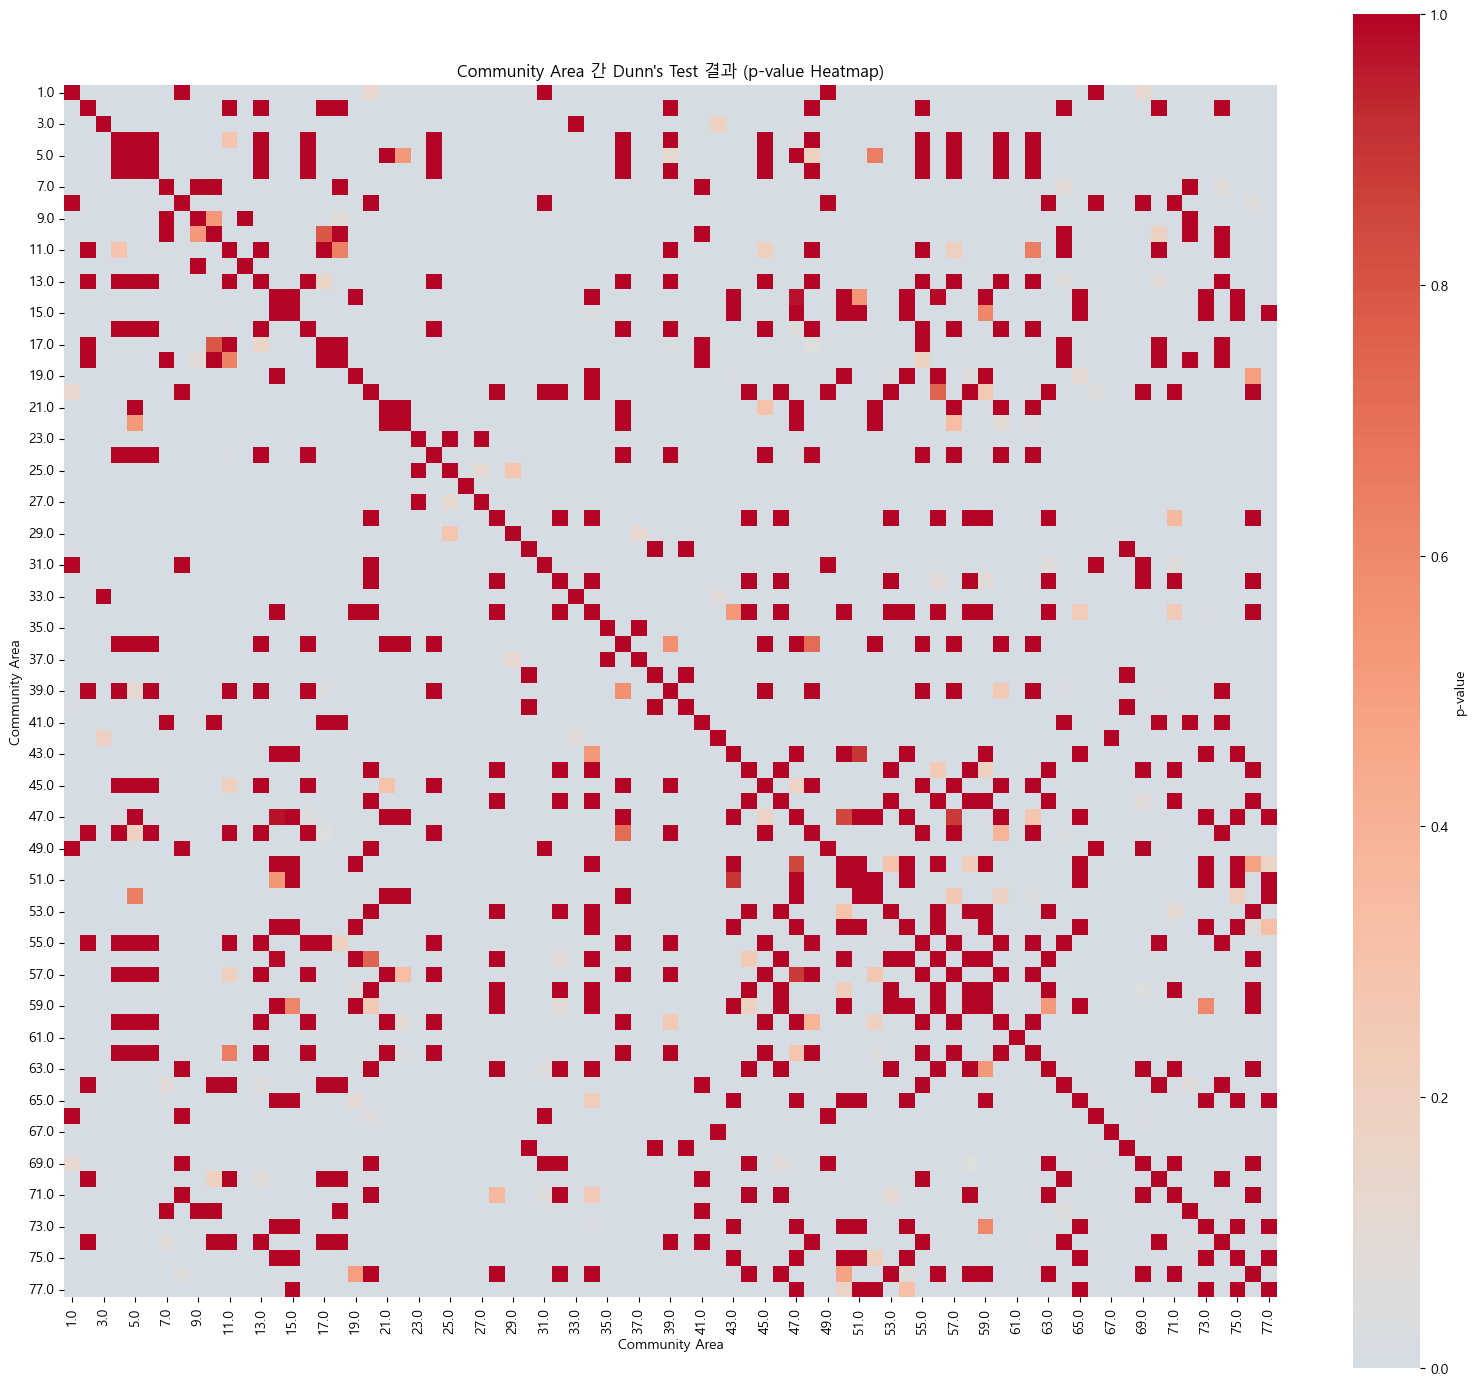

In [46]:
# Dunn's test 실행
dunn_area = sp.posthoc_dunn(
    df_area_valid,
    val_col='Arrest_numeric',
    group_col='Community Area',
    p_adjust='bonferroni'
).round(4)

# 히트맵 시각화
plt.figure(figsize=(16, 14))
sns.heatmap(dunn_area, cmap="coolwarm", center=0.05, square=True, cbar_kws={'label': 'p-value'})
plt.title("Community Area 간 Dunn's Test 결과 (p-value Heatmap)")
plt.xlabel("Community Area")
plt.ylabel("Community Area")
plt.tight_layout()
plt.show()

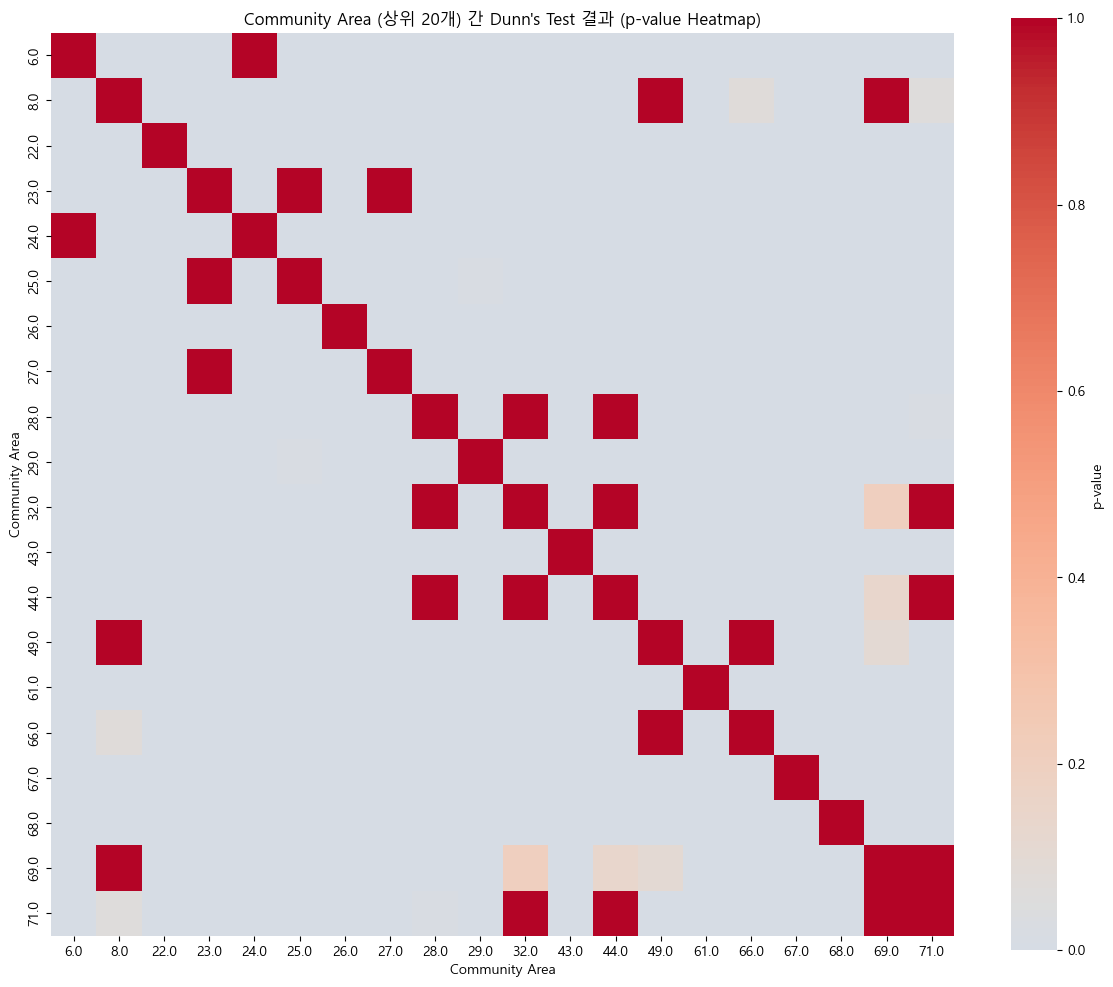

In [47]:
# Community Area 결측 제거
df_area_valid = df.dropna(subset=['Community Area']).copy()

# 사건 수 상위 20개 Community Area 추출
top_20_areas = df_area_valid['Community Area'].value_counts().head(20).index.tolist()
df_top20 = df_area_valid[df_area_valid['Community Area'].isin(top_20_areas)]

# Dunn's test 실행
dunn_top20 = sp.posthoc_dunn(
    df_top20,
    val_col='Arrest_numeric',
    group_col='Community Area',
    p_adjust='bonferroni'
).round(4)

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(dunn_top20, cmap="coolwarm", center=0.05, square=True, cbar_kws={'label': 'p-value'})
plt.title("Community Area (상위 20개) 간 Dunn's Test 결과 (p-value Heatmap)")
plt.xlabel("Community Area")
plt.ylabel("Community Area")
plt.tight_layout()
plt.show()

In [ ]:
#상위 20개 Community Area 간 Dunn’s 사후검정 결과, 다수의 지역 쌍에서 p < 0.05 수준의 통계적 유의미한 체포율 차이가 나타났다.
#특히 6번, 22번, 26번 지역은 여러 구역과 유의한 차이를 보이며, 경찰 대응 체계, 범죄 양상 등의 이질적 특성이 존재할 가능성이 있다.
#반면 69번, 71번 등 일부 구역 간에는 체포율이 통계적으로 유사하여, 유사한 대응 전략을 공유했을 가능성이 있다.

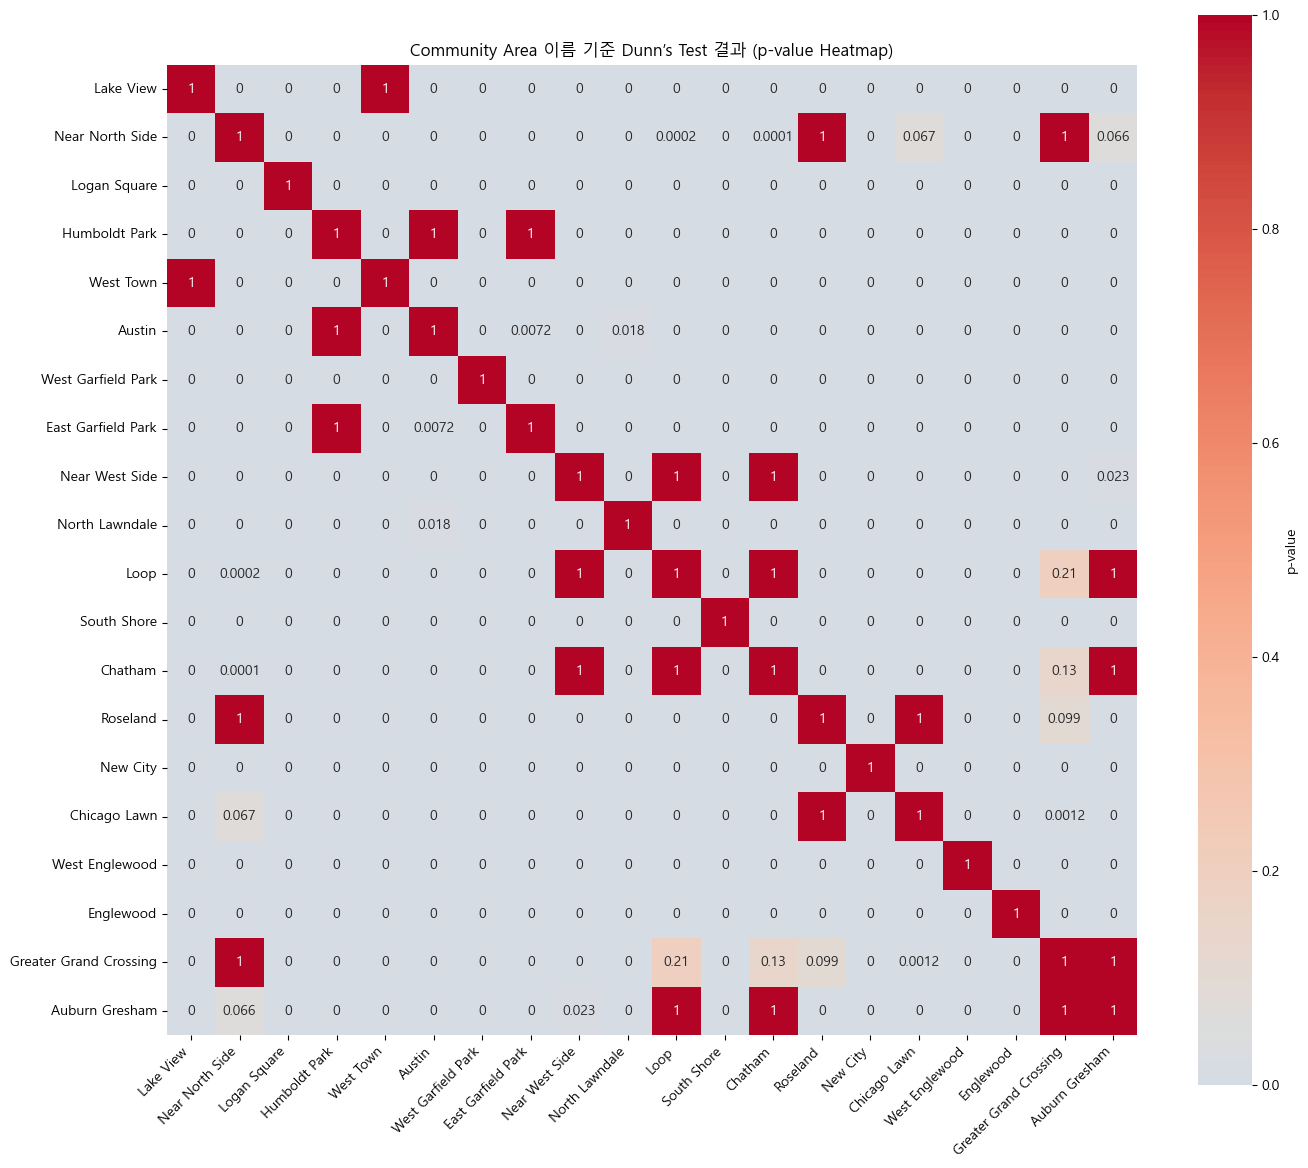

In [70]:
# Community Area 이름 매핑
area_name_map = df.drop_duplicates(subset=['Community Area']).set_index('Community Area')['Community Area Name'].to_dict()

# 상위 20개 Community Area 추출
top_20_areas = df['Community Area'].value_counts().head(20).index.tolist()
df_top20 = df[df['Community Area'].isin(top_20_areas)].copy()
df_top20['Arrest_numeric'] = df_top20['Arrest'].astype(int)

# Dunn's test
dunn_top20 = sp.posthoc_dunn(
    df_top20,
    val_col='Arrest_numeric',
    group_col='Community Area',
    p_adjust='bonferroni'
).round(4)

# 숫자 → 이름으로 라벨 변경
dunn_named = dunn_top20.copy()
dunn_named.index = dunn_named.index.map(area_name_map)
dunn_named.columns = dunn_named.columns.map(area_name_map)

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(dunn_named, cmap="coolwarm", center=0.05, square=True, annot=True ,cbar_kws={'label': 'p-value'})
plt.title("Community Area 이름 기준 Dunn’s Test 결과 (p-value Heatmap)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
**Near North Side**와 **Lake View**

**Logan Square**와 **Humboldt Park**

**West Town**와 **Austin**

**Greater Grand Crossing**와 **Auburn Gresham**

In [49]:
import numpy as np
import pandas as pd

# Dunn’s 결과가 저장되어 있다고 가정 (예: dunn_top20)

# p-value 기준 유의미한 쌍만 추출
sig_pairs = np.where((dunn_top20 < 0.05) & (dunn_top20.notnull()))

# Community Area 번호 → 이름 매핑
area_name_map = df.drop_duplicates(subset=['Community Area']).set_index('Community Area')['Community Area Name'].to_dict()

# 유의미한 쌍 정리
sig_results = []
for i in range(len(sig_pairs[0])):
    area1 = dunn_top20.index[sig_pairs[0][i]]
    area2 = dunn_top20.columns[sig_pairs[1][i]]
    name1 = area_name_map.get(area1, str(area1))
    name2 = area_name_map.get(area2, str(area2))
    pval = dunn_top20.iloc[sig_pairs[0][i], sig_pairs[1][i]]
    sig_results.append((name1, name2, pval))

# p-value 오름차순 정렬 후 상위 20개만 보기
df_sig_top = pd.DataFrame(sorted(sig_results, key=lambda x: x[2])[:20],
                          columns=["Area 1", "Area 2", "p-value"])
print(df_sig_top)


             Area 1                  Area 2  p-value
0         Lake View         Near North Side      0.0
1         Lake View            Logan Square      0.0
2         Lake View           Humboldt Park      0.0
3         Lake View                  Austin      0.0
4         Lake View      West Garfield Park      0.0
5         Lake View      East Garfield Park      0.0
6         Lake View          Near West Side      0.0
7         Lake View          North Lawndale      0.0
8         Lake View                    Loop      0.0
9         Lake View             South Shore      0.0
10        Lake View                 Chatham      0.0
11        Lake View                Roseland      0.0
12        Lake View                New City      0.0
13        Lake View            Chicago Lawn      0.0
14        Lake View          West Englewood      0.0
15        Lake View               Englewood      0.0
16        Lake View  Greater Grand Crossing      0.0
17        Lake View          Auburn Gresham   

In [ ]:
import pandas as pd


# 2. 체포 여부 숫자형으로 변환
df_valid['Arrest_numeric'] = df_valid['Arrest'].astype(int)

# 3. Beat별 평균 체포율 계산
mean_arrest_by_beat = df_valid.groupby("Beat")["Arrest_numeric"].mean()

# 상위 10개 체포율 높은 Beat
top10 = mean_arrest_by_beat.sort_values(ascending=False).head(10)
print("평균 체포율 상위 10개 Beat:")
print(top10)

# 하위 10개 체포율 낮은 Beat
bottom10 = mean_arrest_by_beat.sort_values().head(10)
print("\n평균 체포율 하위 10개 Beat:")
print(bottom10)

    Community Area Community Area Name  Arrest_numeric
25            26.0  West Garfield Park        0.426501
26            27.0  East Garfield Park        0.375536
22            23.0       Humboldt Park        0.371766
24            25.0              Austin        0.368622
28            29.0      North Lawndale        0.363055
36            37.0         Fuller Park        0.348071
34            35.0             Douglas        0.347736
60            61.0            New City        0.318855
32            33.0     Near South Side        0.295580
2              3.0              Uptown        0.293127
    Community Area Community Area Name  Arrest_numeric
11            12.0         Forest Glen        0.102897
8              9.0         Edison Park        0.111635
71            72.0             Beverly        0.130328
6              7.0        Lincoln Park        0.134986
9             10.0        Norwood Park        0.137887
40            41.0           Hyde Park        0.142582
17        

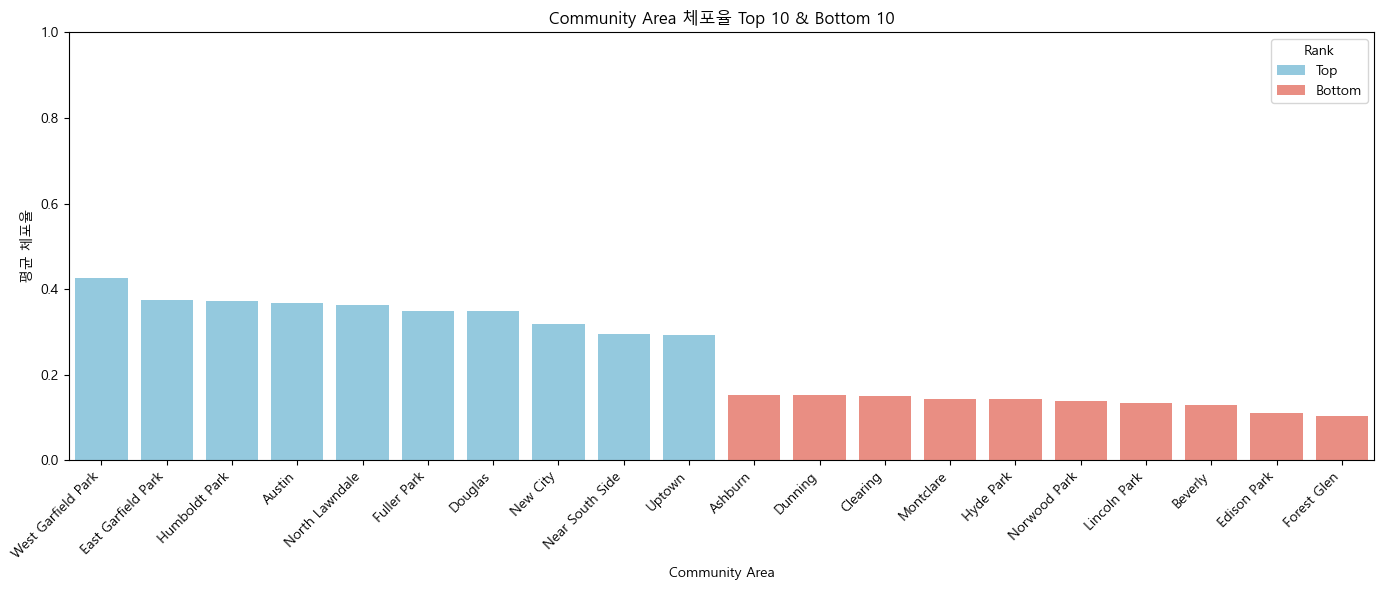

In [55]:
# Arrest를 숫자형으로 변환
df['Arrest_numeric'] = df['Arrest'].astype(int)

# Community Area 결측 제거
df_valid = df.dropna(subset=['Community Area']).copy()

# 평균 체포율 계산
mean_arrest_by_area = (
    df_valid
    .groupby(["Community Area", "Community Area Name"])["Arrest_numeric"]
    .mean()
    .reset_index()
)

# 상위/하위 10개 추출
top10 = mean_arrest_by_area.sort_values(by="Arrest_numeric", ascending=False).head(10)
bottom10 = mean_arrest_by_area.sort_values(by="Arrest_numeric", ascending=True).head(10)
print(top10)
print(bottom10)
# 시각화를 위한 데이터 결합
combined = pd.concat([top10, bottom10])
combined['Rank'] = ['Top'] * 10 + ['Bottom'] * 10
combined_sorted = combined.sort_values(by="Arrest_numeric", ascending=False)

# 바플롯 시각화
plt.figure(figsize=(14, 6))
sns.barplot(
    data=combined_sorted,
    x='Community Area Name',
    y='Arrest_numeric',
    hue='Rank',
    palette=['skyblue', 'salmon']
)
plt.title("Community Area 체포율 Top 10 & Bottom 10")
plt.ylabel("평균 체포율")
plt.xlabel("Community Area")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

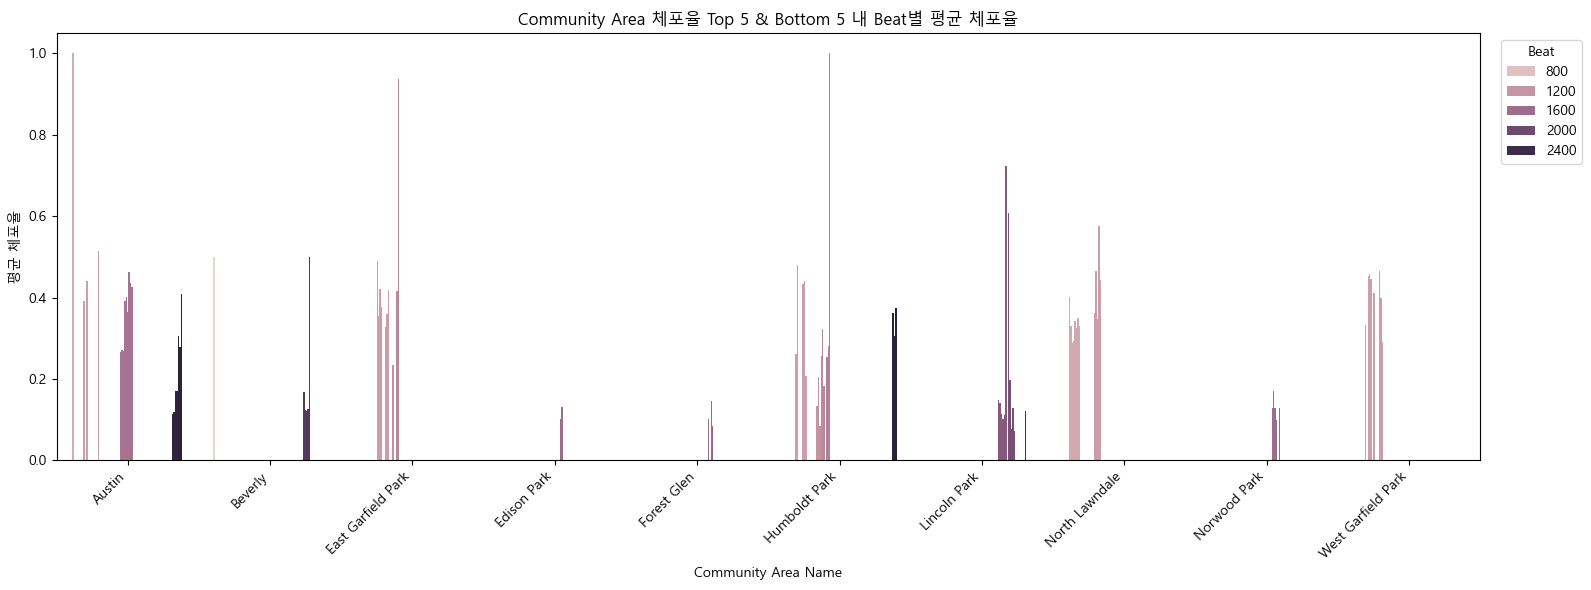

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Community Area 평균 체포율 계산
area_mean = df_valid.groupby('Community Area Name')['Arrest_numeric'].mean()

# 2. Top 5 & Bottom 5 Community Area 선택
top5_areas = area_mean.sort_values(ascending=False).head(5).index.tolist()
bottom5_areas = area_mean.sort_values().head(5).index.tolist()
selected_areas = top5_areas + bottom5_areas

# 3. 해당 지역만 필터링
df_selected = df_valid[df_valid['Community Area Name'].isin(selected_areas)]

# 4. Community Area + Beat 조합별 평균 체포율 계산
area_beat_mean = df_selected.groupby(['Community Area Name', 'Beat'])['Arrest_numeric'].mean().reset_index()

# 5. 시각화
plt.figure(figsize=(16, 6))
sns.barplot(data=area_beat_mean, x='Community Area Name', y='Arrest_numeric', hue='Beat')
plt.title("Community Area 체포율 Top 5 & Bottom 5 내 Beat별 평균 체포율")
plt.ylabel("평균 체포율")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Beat", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


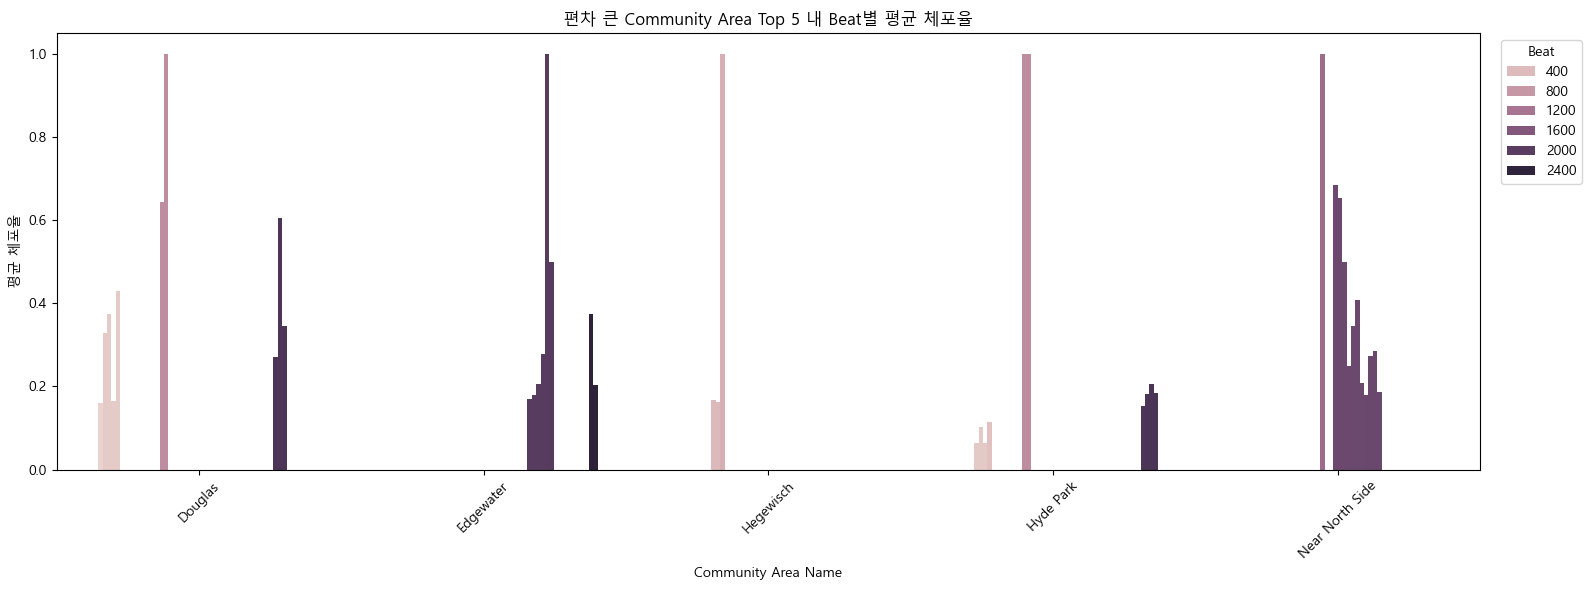

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Community Area + Beat 기준 체포율 평균 계산
beat_area_mean = df_valid.groupby(['Community Area Name', 'Beat'])['Arrest_numeric'].mean().reset_index()

# Community Area별로 Beat의 체포율 표준편차 계산
area_std = beat_area_mean.groupby('Community Area Name')['Arrest_numeric'].std().sort_values(ascending=False)

# 표준편차 기준 상위 5개 지역만 선택
top_std_areas = area_std.head(5).index.tolist()
df_zoom = beat_area_mean[beat_area_mean['Community Area Name'].isin(top_std_areas)]

# 시각화
plt.figure(figsize=(16, 6))
sns.barplot(data=df_zoom, x="Community Area Name", y="Arrest_numeric", hue="Beat")
plt.title("편차 큰 Community Area Top 5 내 Beat별 평균 체포율")
plt.ylabel("평균 체포율")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title="Beat")
plt.tight_layout()
plt.show()



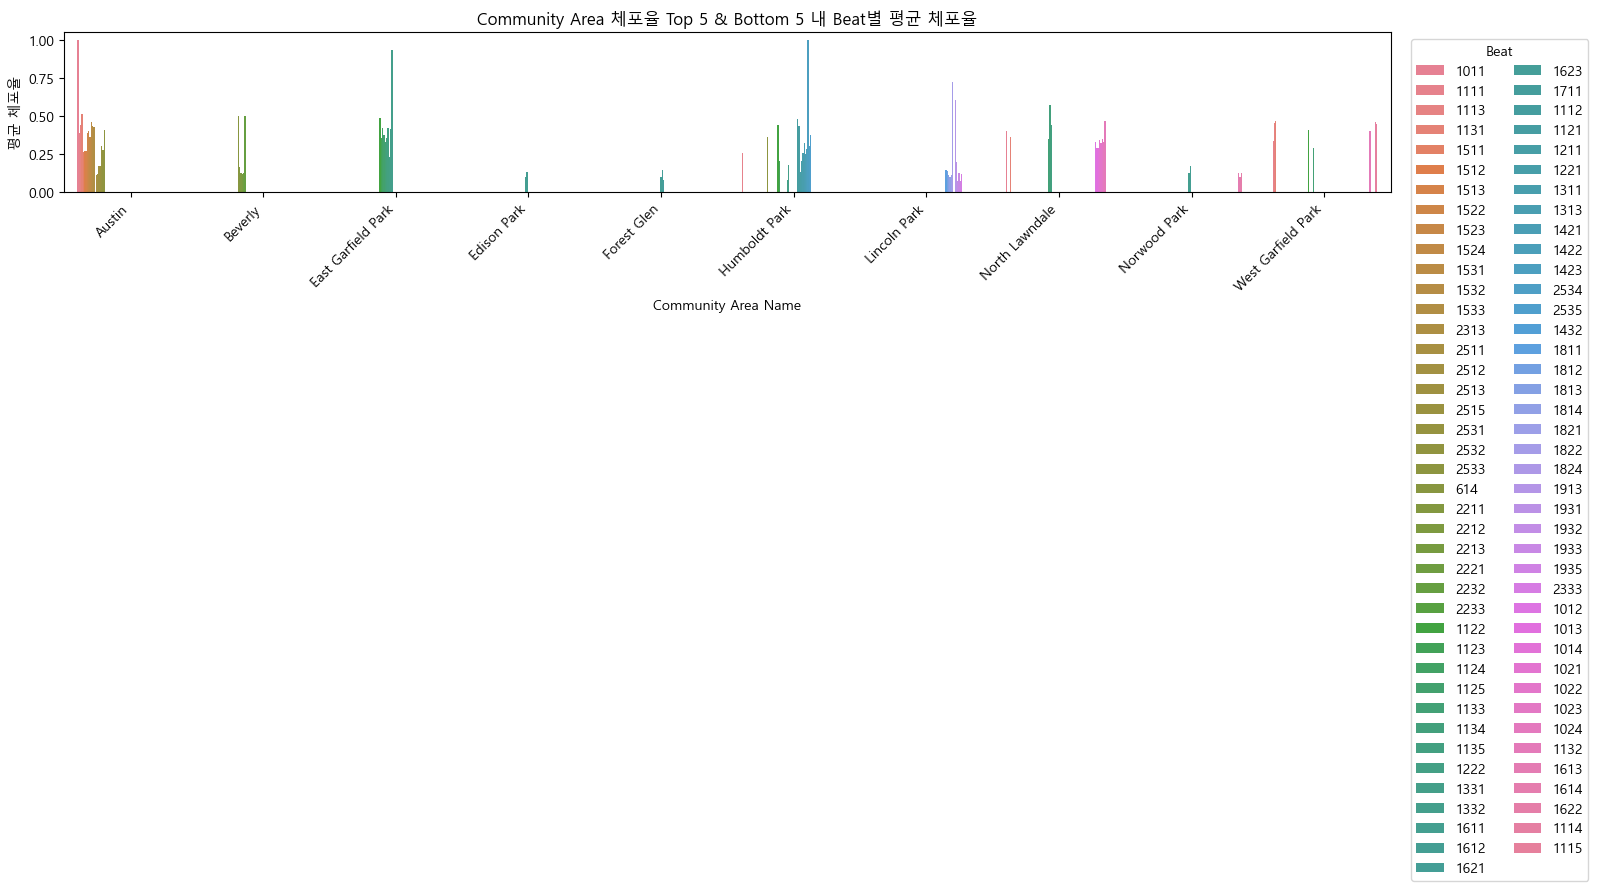

In [59]:
# Beat를 문자열로 바꾸기
area_beat_mean['Beat'] = area_beat_mean['Beat'].astype(str)

plt.figure(figsize=(16, 6))
sns.barplot(data=area_beat_mean, x='Community Area Name', y='Arrest_numeric', hue='Beat')
plt.title("Community Area 체포율 Top 5 & Bottom 5 내 Beat별 평균 체포율")
plt.ylabel("평균 체포율")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Beat", bbox_to_anchor=(1.01, 1), loc='upper left', ncol=2)  # <- 모든 범례 표시
plt.tight_layout()
plt.show()


In [60]:
beat_std = df_valid.groupby(['Community Area Name', 'Beat'])['Arrest_numeric'].mean()
std_by_area = beat_std.groupby('Community Area Name').std().sort_values(ascending=False)


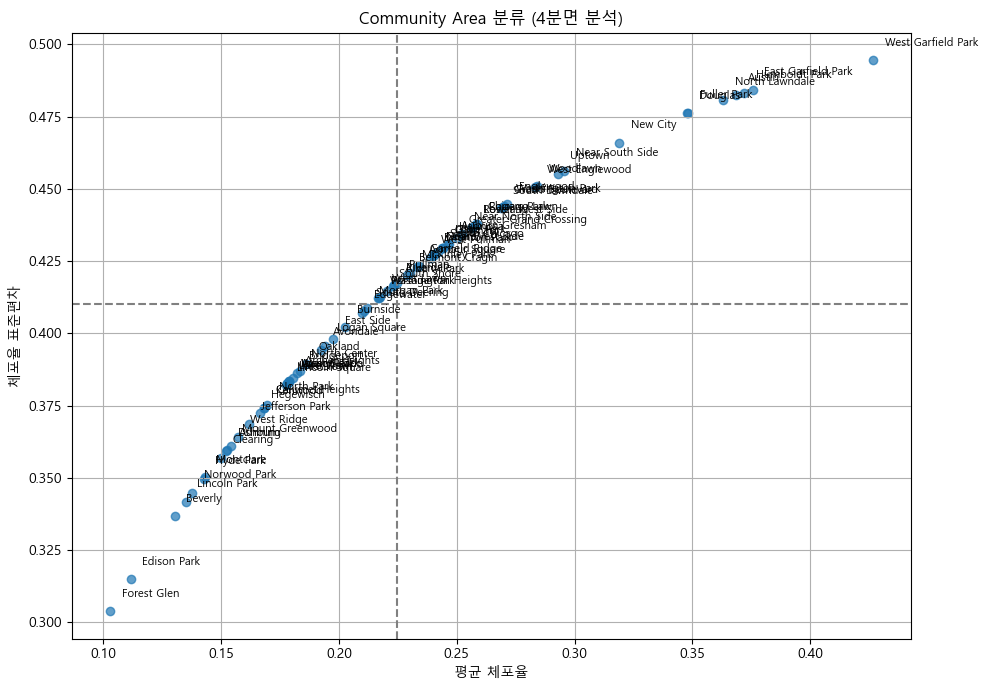

In [61]:
import matplotlib.pyplot as plt

# Community Area별 평균 체포율 & 표준편차
mean_std = df_valid.groupby("Community Area Name")["Arrest_numeric"].agg(['mean', 'std']).dropna()

# 전체 평균선
mean_arrest = mean_std['mean'].mean()
mean_stddev = mean_std['std'].mean()

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(mean_std['mean'], mean_std['std'], alpha=0.7)

# 기준선
plt.axhline(mean_stddev, color='gray', linestyle='--')
plt.axvline(mean_arrest, color='gray', linestyle='--')

plt.xlabel("평균 체포율")
plt.ylabel("체포율 표준편차")
plt.title("Community Area 분류 (4분면 분석)")
plt.grid(True)

for name, row in mean_std.iterrows():
    plt.text(row['mean'] + 0.005, row['std'] + 0.005, name, fontsize=8)

plt.tight_layout()
plt.show()


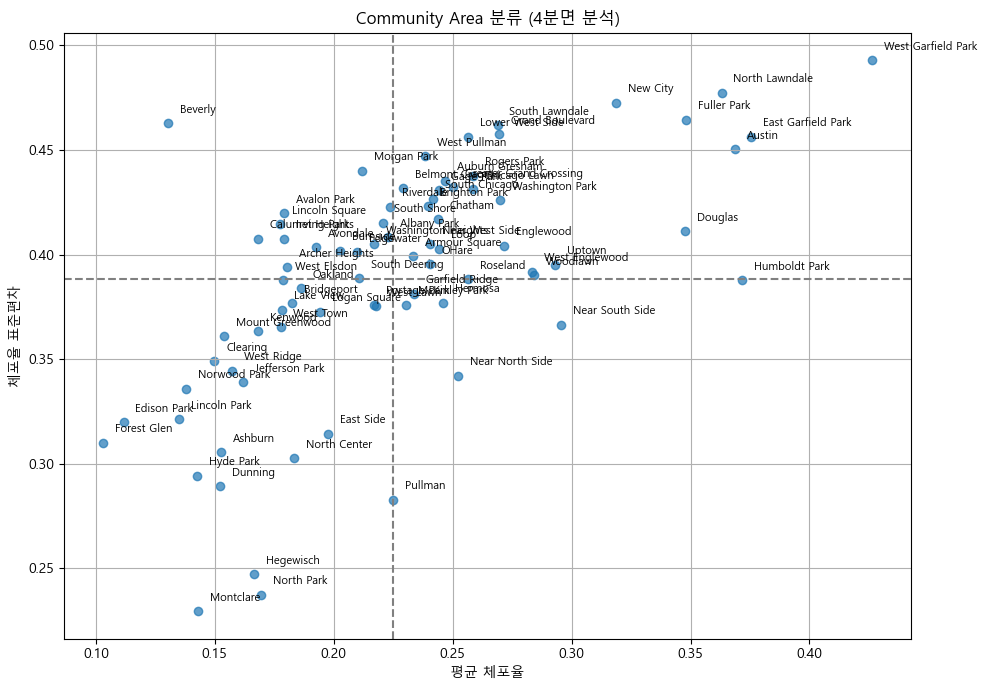

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# 'Arrest'를 0과 1로 변환 (체포 여부)
df['Arrest_numeric'] = df['Arrest'].astype(int)

# 각 지역별 평균 체포율
mean_arrest_rate = df.groupby('Community Area Name')['Arrest_numeric'].mean()

# 각 지역 내 비트별 체포율 표준편차 계산
std_dev_per_area_beat = df.groupby(['Community Area Name', 'Beat'])['Arrest_numeric'].std().groupby('Community Area Name').mean()

# 두 값을 결합
arrest_stats = pd.DataFrame({
    'Average Arrest Rate': mean_arrest_rate,
    'Arrest Rate Std Dev (per Beat)': std_dev_per_area_beat
})

# 전체 평균선
mean_arrest = arrest_stats['Average Arrest Rate'].mean()
mean_stddev = arrest_stats['Arrest Rate Std Dev (per Beat)'].mean()

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(arrest_stats['Average Arrest Rate'], arrest_stats['Arrest Rate Std Dev (per Beat)'], alpha=0.7)

# 기준선 (전체 평균)
plt.axhline(mean_stddev, color='gray', linestyle='--')
plt.axvline(mean_arrest, color='gray', linestyle='--')

# 제목 및 라벨
plt.title("Community Area 분류 (4분면 분석)")
plt.xlabel("평균 체포율")
plt.ylabel("체포율 표준편차")
plt.grid(True)

# 각 지역 이름 추가
for name, row in arrest_stats.iterrows():
    plt.text(row['Average Arrest Rate'] + 0.005, row['Arrest Rate Std Dev (per Beat)'] + 0.005, name, fontsize=8)

plt.tight_layout()
plt.show()


Pearson correlation coefficient: 0.6284681071314298
P-value: 9.397169785286195e-10


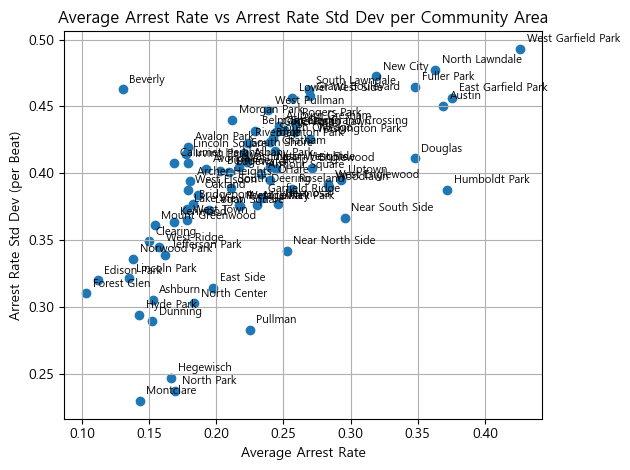

In [75]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# 'Arrest'를 0과 1로 변환 (체포 여부)
df['Arrest_numeric'] = df['Arrest'].astype(int)

# 각 지역별 평균 체포율
mean_arrest_rate = df.groupby('Community Area Name')['Arrest_numeric'].mean()

# 각 지역 내 Beat별로 표준편차 계산 (Beat로 그룹화)
std_dev_per_area = df.groupby(['Community Area Name', 'Beat'])['Arrest_numeric'].std().groupby('Community Area Name').mean()

# 두 값 결합
arrest_stats = pd.DataFrame({
    'Average Arrest Rate': mean_arrest_rate,
    'Arrest Rate Std Dev': std_dev_per_area
})

# 피어슨 상관 계수 계산
correlation, p_value = stats.pearsonr(arrest_stats['Average Arrest Rate'], arrest_stats['Arrest Rate Std Dev'])

# 결과 출력
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# 상관 관계 시각화
plt.scatter(arrest_stats['Average Arrest Rate'], arrest_stats['Arrest Rate Std Dev'])
plt.title('Average Arrest Rate vs Arrest Rate Std Dev per Community Area')
plt.xlabel('Average Arrest Rate')
plt.ylabel('Arrest Rate Std Dev (per Beat)')
plt.grid(True)

# 각 지역 이름 추가
for name, row in arrest_stats.iterrows():
    plt.text(row['Average Arrest Rate'] + 0.005, row['Arrest Rate Std Dev'] + 0.005, name, fontsize=8)

plt.tight_layout()
plt.show()


Pearson correlation coefficient: 0.9712691261012409
P-value: 1.645650528280329e-48
통계적으로 유의미한 상관 관계가 있습니다.


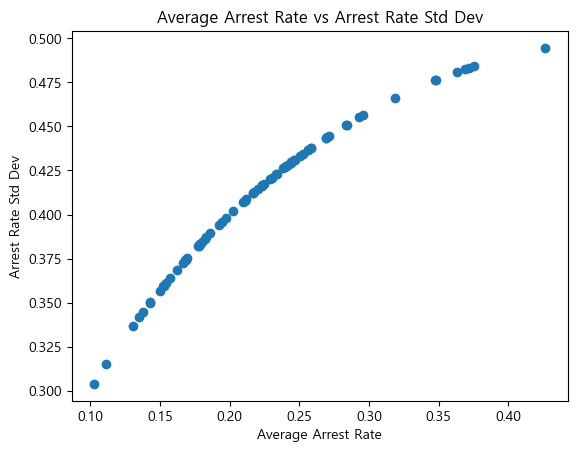

In [72]:
# 각 지역별로 체포 여부 계산 (True/False로 계산된 체포율)
df['Arrest'] = df['Arrest'].astype(int)  # 체포 여부를 0과 1로 변환

# 각 Community Area별 체포율 계산
arrest_rate_by_area = df.groupby('Community Area Name')['Arrest'].mean()

# 각 Community Area별 체포율 표준편차 계산
std_dev_by_area = df.groupby('Community Area Name')['Arrest'].std()

# 평균 체포율과 표준편차 데이터를 DataFrame으로 합치기
arrest_stats = pd.DataFrame({
    'Average Arrest Rate': arrest_rate_by_area,
    'Arrest Rate Std Dev': std_dev_by_area
})

# 피어슨 상관 계수 계산
correlation, p_value = stats.pearsonr(arrest_stats['Average Arrest Rate'], arrest_stats['Arrest Rate Std Dev'])

# 결과 출력
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# 결과 해석
if p_value < 0.05:
    print("통계적으로 유의미한 상관 관계가 있습니다.")
else:
    print("상관 관계가 통계적으로 유의미하지 않습니다.")

# 상관 관계를 시각화
plt.scatter(arrest_stats['Average Arrest Rate'], arrest_stats['Arrest Rate Std Dev'])
plt.title('Average Arrest Rate vs Arrest Rate Std Dev')
plt.xlabel('Average Arrest Rate')
plt.ylabel('Arrest Rate Std Dev')
plt.show()


In [62]:
import pandas as pd

# Arrest를 숫자형으로 변환
df['Arrest_numeric'] = df['Arrest'].astype(int)

# Community Area별 집계
ca_grouped = df.groupby("Community Area")

# ① 범죄 발생 건수
crime_counts = ca_grouped.size()

# ② 평균 체포율
mean_arrest_rates = ca_grouped["Arrest_numeric"].mean()

# ③ Beat 간 체포율 표준편차 계산
std_by_beat = df.groupby(["Community Area", "Beat"])["Arrest_numeric"].mean().groupby("Community Area").std()

# 데이터 통합
safety_df = pd.DataFrame({
    "Crime Count": crime_counts,
    "Mean Arrest Rate": mean_arrest_rates,
    "Beat Arrest Std": std_by_beat
})

# 결측치 제거 (표준편차 없는 경우 등)
safety_df.dropna(inplace=True)

# 정규화 (Min-Max Scaling)
safety_df["Crime Score"] = (safety_df["Crime Count"] - safety_df["Crime Count"].min()) / (safety_df["Crime Count"].max() - safety_df["Crime Count"].min())
safety_df["Arrest Score"] = (safety_df["Mean Arrest Rate"] - safety_df["Mean Arrest Rate"].min()) / (safety_df["Mean Arrest Rate"].max() - safety_df["Mean Arrest Rate"].min())
safety_df["Unbalance Score"] = (safety_df["Beat Arrest Std"] - safety_df["Beat Arrest Std"].min()) / (safety_df["Beat Arrest Std"].max() - safety_df["Beat Arrest Std"].min())

# 종합 안전 점수 계산 (높을수록 안전)
safety_df["Safety Score"] = (
    (1 - safety_df["Crime Score"]) * 0.4 +
    safety_df["Arrest Score"] * 0.4 +
    (1 - safety_df["Unbalance Score"]) * 0.2
)

# 정렬
safety_df_sorted = safety_df.sort_values("Safety Score", ascending=False)

# 결과 보기
import IPython
IPython.display.display(safety_df_sorted.head(10))  # 상위 10개 안전 지역


,Crime Count,Mean Arrest Rate,Beat Arrest Std,Crime Score,Arrest Score,Unbalance Score,Safety Score
Community Area,,,,,,,
26.0,151777,0.426501,0.064235,0.285766,1.000000,0.113379,0.863018
37.0,27503,0.348071,0.152235,0.038302,0.757637,0.314660,0.824802
27.0,152201,0.375536,0.189227,0.286611,0.842510,0.399270,0.742506
33.0,65742,0.295580,0.160680,0.114447,0.595428,0.333975,0.725598
54.0,38078,0.223515,0.014665,0.059360,0.372733,0.000000,0.725349
35.0,96050,0.347736,0.275580,0.174798,0.756600,0.596783,0.713364
29.0,238022,0.363055,0.079970,0.457504,0.803939,0.149369,0.708700
58.0,79214,0.239743,0.037570,0.141273,0.422881,0.052390,0.702165
20.0,49725,0.246134,0.106755,0.082552,0.442630,0.210634,0.701904


In [64]:
# 매핑 딕셔너리 생성
area_name_map = df.drop_duplicates(subset=['Community Area'])\
                  .set_index('Community Area')['Community Area Name'].to_dict()

# safety_df에 이름 컬럼 추가
safety_df['Community Area Name'] = safety_df.index.map(area_name_map)


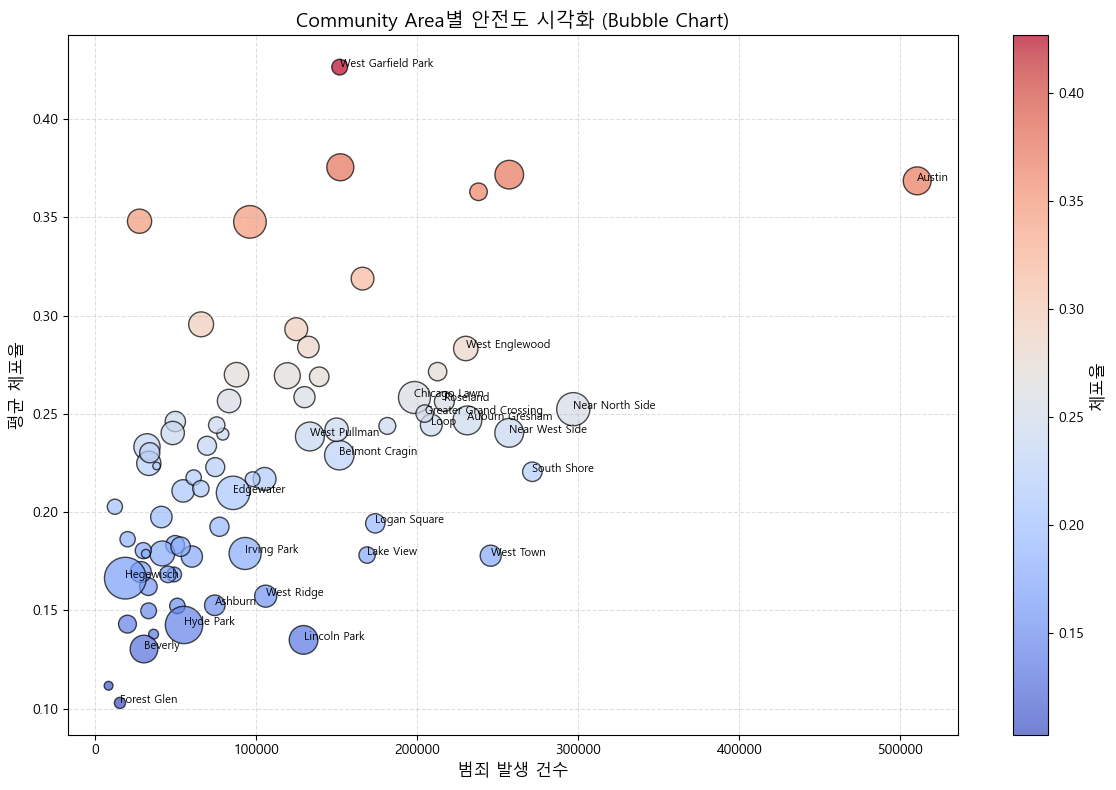

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가독성 향상을 위한 설정
plt.figure(figsize=(12, 8))

# 색상은 체포율 기준으로, 포인트 크기는 표준편차 기준
scatter = plt.scatter(
    safety_df['Crime Count'],
    safety_df['Mean Arrest Rate'],
    s=safety_df['Beat Arrest Std'] * 2000,  # 점 크기 조정
    c=safety_df['Mean Arrest Rate'],        # 색상: 체포율
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='k'
)

# 축 라벨
plt.xlabel("범죄 발생 건수", fontsize=12)
plt.ylabel("평균 체포율", fontsize=12)
plt.title("Community Area별 안전도 시각화 (Bubble Chart)", fontsize=14)

# 색상 바 추가 (체포율 기준)
cbar = plt.colorbar(scatter)
cbar.set_label('체포율', fontsize=12)

# 주요 지점 라벨링 (선택사항)
for idx, row in safety_df.iterrows():
    if row['Safety Score'] > 0.85 or row['Safety Score'] < 0.6:
        plt.text(row['Crime Count'], row['Mean Arrest Rate'], row['Community Area Name'], fontsize=8)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


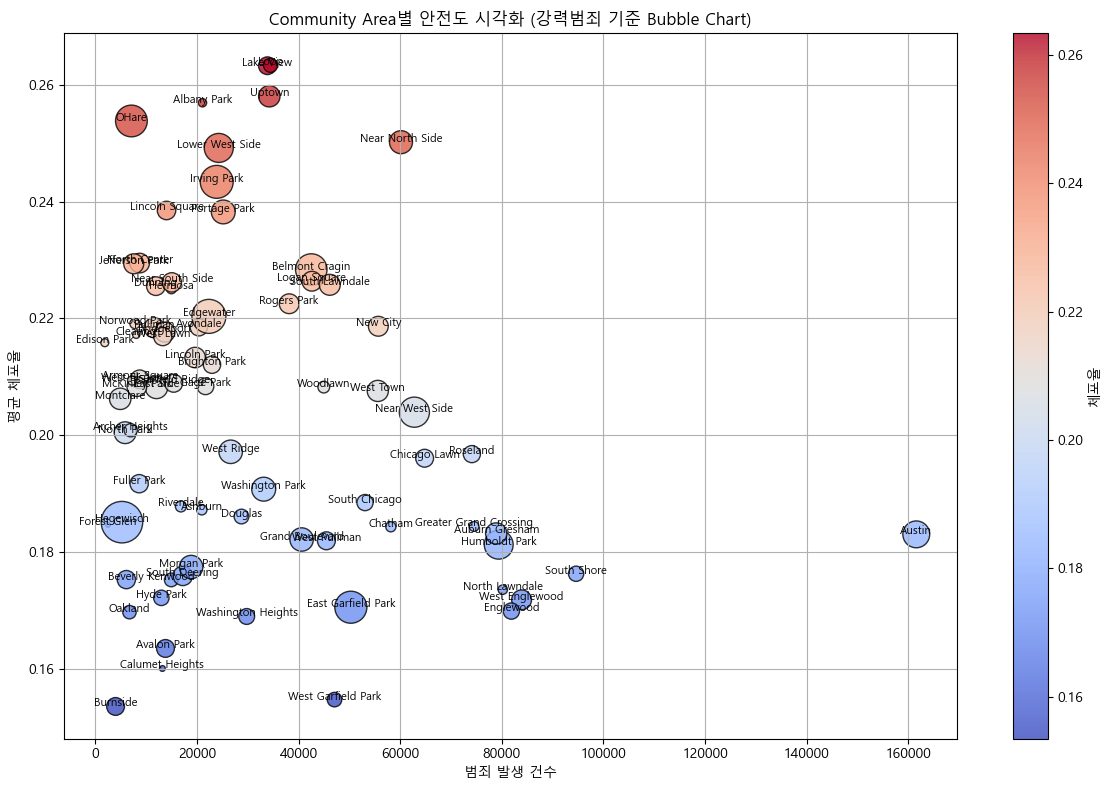

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 강력범죄 유형 정의
violent_crimes = ['HOMICIDE', 'CRIM SEXUAL ASSAULT', 'ROBBERY', 'ASSAULT', 'BATTERY']


# 2. 강력범죄 필터링
df_violent = df[df['Primary Type'].isin(violent_crimes)].copy()
df_violent['Arrest_numeric'] = df_violent['Arrest'].astype(int)

# 3. Community Area별 통계 계산
agg_data = df_violent.groupby('Community Area').agg(
    Crime_Count=('ID', 'count'),
    Mean_Arrest_Rate=('Arrest_numeric', 'mean'),
    Beat_Arrest_Std=('Arrest_numeric', lambda x: df_violent.loc[x.index].groupby('Beat')['Arrest_numeric'].mean().std())
).dropna().reset_index()

# 4. Community Area 이름 매핑 (필요 시)
if 'Community Area Name' in df.columns:
    area_map = df.drop_duplicates('Community Area')[['Community Area', 'Community Area Name']].set_index('Community Area')['Community Area Name'].to_dict()
    agg_data['Community Area Name'] = agg_data['Community Area'].map(area_map)
else:
    agg_data['Community Area Name'] = agg_data['Community Area'].astype(str)

# 5. 시각화
plt.figure(figsize=(12, 8))
bubble = plt.scatter(
    x=agg_data['Crime_Count'],
    y=agg_data['Mean_Arrest_Rate'],
    s=agg_data['Beat_Arrest_Std'] * 2000,  # 버블 크기 (조절 가능)
    c=agg_data['Mean_Arrest_Rate'],  # 색상
    cmap='coolwarm',
    alpha=0.8,
    edgecolors='k'
)

# 6. 라벨
for i, row in agg_data.iterrows():
    plt.text(row['Crime_Count'], row['Mean_Arrest_Rate'], row['Community Area Name'], fontsize=8, ha='center')

# 7. 스타일
plt.xlabel("범죄 발생 건수")
plt.ylabel("평균 체포율")
plt.title("Community Area별 안전도 시각화 (강력범죄 기준 Bubble Chart)")
cbar = plt.colorbar(bubble)
cbar.set_label("체포율")
plt.grid(True)
plt.tight_layout()
plt.show()


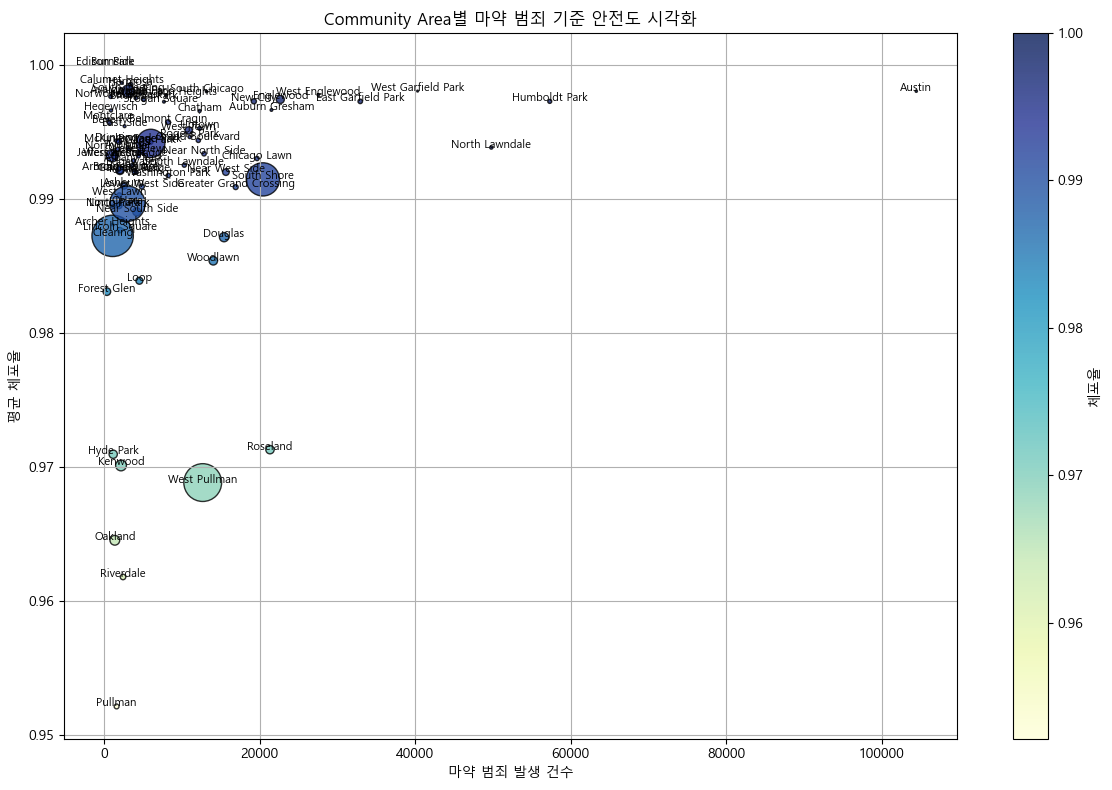

In [67]:
# 1. 마약 범죄 필터링
df_drug = df[df['Primary Type'] == 'NARCOTICS'].copy()
df_drug['Arrest_numeric'] = df_drug['Arrest'].astype(int)

# 2. Community Area별 통계
agg_drug = df_drug.groupby('Community Area').agg(
    Crime_Count=('ID', 'count'),
    Mean_Arrest_Rate=('Arrest_numeric', 'mean'),
    Beat_Arrest_Std=('Arrest_numeric', lambda x: df_drug.loc[x.index].groupby('Beat')['Arrest_numeric'].mean().std())
).dropna().reset_index()

# 3. 이름 매핑
agg_drug['Community Area Name'] = agg_drug['Community Area'].map(area_map)

# 4. 시각화
plt.figure(figsize=(12, 8))
bubble = plt.scatter(
    x=agg_drug['Crime_Count'],
    y=agg_drug['Mean_Arrest_Rate'],
    s=agg_drug['Beat_Arrest_Std'] * 2000,
    c=agg_drug['Mean_Arrest_Rate'],
    cmap='YlGnBu',
    edgecolors='k',
    alpha=0.8
)
for i, row in agg_drug.iterrows():
    plt.text(row['Crime_Count'], row['Mean_Arrest_Rate'], row['Community Area Name'], fontsize=8, ha='center')
plt.xlabel("마약 범죄 발생 건수")
plt.ylabel("평균 체포율")
plt.title("Community Area별 마약 범죄 기준 안전도 시각화")
plt.colorbar(bubble, label="체포율")
plt.grid(True)
plt.tight_layout()
plt.show()


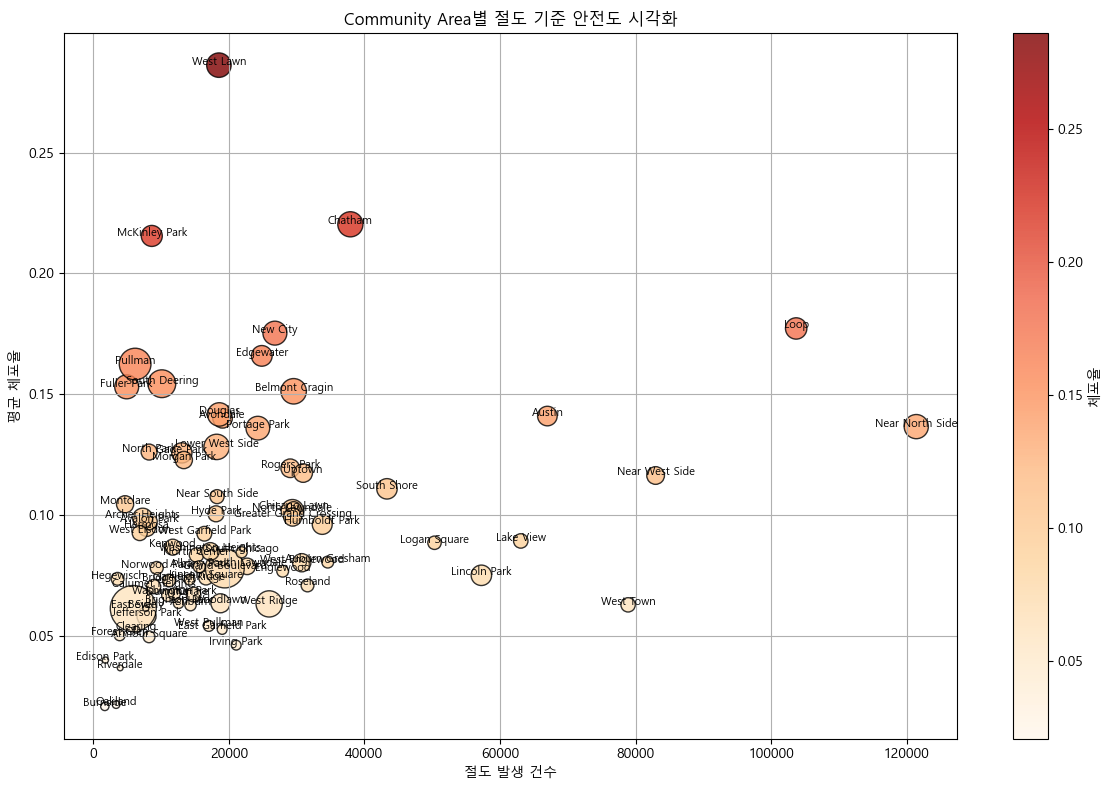

In [68]:
# 1. 절도 범죄 필터링
df_theft = df[df['Primary Type'] == 'THEFT'].copy()
df_theft['Arrest_numeric'] = df_theft['Arrest'].astype(int)

# 2. 통계 계산
agg_theft = df_theft.groupby('Community Area').agg(
    Crime_Count=('ID', 'count'),
    Mean_Arrest_Rate=('Arrest_numeric', 'mean'),
    Beat_Arrest_Std=('Arrest_numeric', lambda x: df_theft.loc[x.index].groupby('Beat')['Arrest_numeric'].mean().std())
).dropna().reset_index()

# 3. 이름 매핑
agg_theft['Community Area Name'] = agg_theft['Community Area'].map(area_map)

# 4. 시각화
plt.figure(figsize=(12, 8))
bubble = plt.scatter(
    x=agg_theft['Crime_Count'],
    y=agg_theft['Mean_Arrest_Rate'],
    s=agg_theft['Beat_Arrest_Std'] * 2000,
    c=agg_theft['Mean_Arrest_Rate'],
    cmap='OrRd',
    edgecolors='k',
    alpha=0.8
)
for i, row in agg_theft.iterrows():
    plt.text(row['Crime_Count'], row['Mean_Arrest_Rate'], row['Community Area Name'], fontsize=8, ha='center')
plt.xlabel("절도 발생 건수")
plt.ylabel("평균 체포율")
plt.title("Community Area별 절도 기준 안전도 시각화")
plt.colorbar(bubble, label="체포율")
plt.grid(True)
plt.tight_layout()
plt.show()
